## Modeling

We begin by importing necessary libraries

In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import df_helper

dfh = df_helper.df_helper()

### Inspecting the data

In [2]:
model_df = pd.read_csv("data/cleaned_data.csv")
dfh.drop_columns(
    model_df,[
        "subject_id",
        "hadm_id",
        "drug_type",
        "admittime",
        "dischtime",
        "language",
])
#convert bmi column to numeric
model_df.bmi = model_df.bmi.astype(float)


model_df.head()

,drug,age,diagnosis,gender,admission_type,admission_location,insurance,marital_status,race,bmi,height,weight,bp_systolic,bp_diastolic,died,length_of_stay
0,Fentanyl Citrate,71,"Urinary tract infection, site not specified",F,EW EMER.,EMERGENCY ROOM,Other,SINGLE,WHITE,27.7,1.59,69.17,128.0,80.0,False,21
1,Fentanyl Citrate,71,Acute respiratory failure,F,EW EMER.,EMERGENCY ROOM,Other,SINGLE,WHITE,27.7,1.59,69.17,128.0,80.0,False,21
2,Fentanyl Citrate,71,"Asthma, unspecified type, unspecified",F,EW EMER.,EMERGENCY ROOM,Other,SINGLE,WHITE,27.7,1.59,69.17,128.0,80.0,False,21
3,Fentanyl Citrate,71,Solitary pulmonary nodule,F,EW EMER.,EMERGENCY ROOM,Other,SINGLE,WHITE,27.7,1.59,69.17,128.0,80.0,False,21
4,Fentanyl Citrate,71,Streptococcus infection in conditions classifi...,F,EW EMER.,EMERGENCY ROOM,Other,SINGLE,WHITE,27.7,1.59,69.17,128.0,80.0,False,21


Next we check for correlations between numerical features

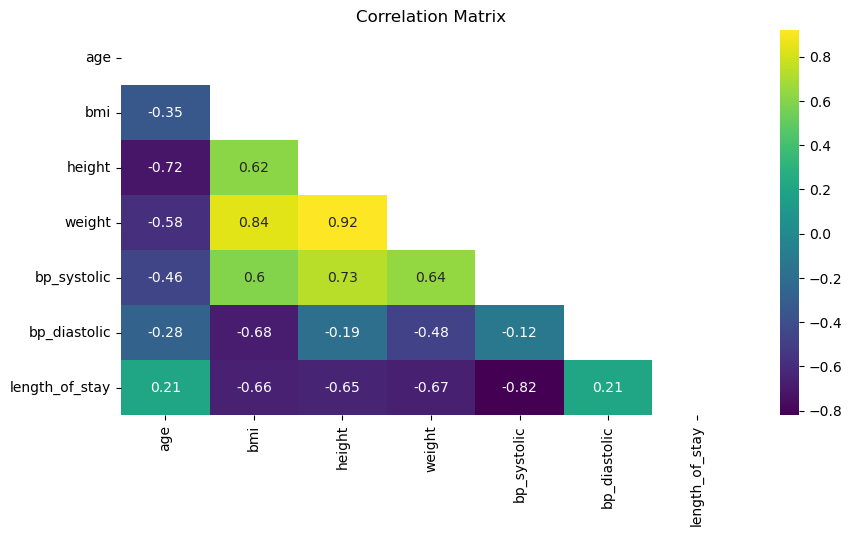

In [3]:
correlations_matrix = model_df[dfh.numerical_columns(model_df)].corr(method='spearman') 
correlations_matrix=round(correlations_matrix.corr(),2)

mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, map = plt.subplots(figsize=(10, 5))
map = sns.heatmap(correlations_matrix, mask=mask, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

**Observations**
- The correlation between weight and BMI is very strong. Drop BMI in favour of weight.
- Height and weight are highly correlated. Drop height in favour of weight.

In [4]:
dfh.drop_columns(
    model_df,[
        "bmi",
        "height",
    ]
)
print(model_df.info())
model_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025833 entries, 0 to 1025832
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   drug                1025833 non-null  object 
 1   age                 1025833 non-null  int64  
 2   diagnosis           1025833 non-null  object 
 3   gender              1025833 non-null  object 
 4   admission_type      1025833 non-null  object 
 5   admission_location  1025833 non-null  object 
 6   insurance           1025833 non-null  object 
 7   marital_status      1025833 non-null  object 
 8   race                1025833 non-null  object 
 9   weight              1025833 non-null  float64
 10  bp_systolic         1025833 non-null  float64
 11  bp_diastolic        1025833 non-null  float64
 12  died                1025833 non-null  bool   
 13  length_of_stay      1025833 non-null  int64  
dtypes: bool(1), float64(3), int64(2), object(8)
memory usage: 102.7+ M

,drug,age,diagnosis,gender,admission_type,admission_location,insurance,marital_status,race,weight,bp_systolic,bp_diastolic,died,length_of_stay
0,Fentanyl Citrate,71,"Urinary tract infection, site not specified",F,EW EMER.,EMERGENCY ROOM,Other,SINGLE,WHITE,69.17,128.0,80.0,False,21
1,Fentanyl Citrate,71,Acute respiratory failure,F,EW EMER.,EMERGENCY ROOM,Other,SINGLE,WHITE,69.17,128.0,80.0,False,21
2,Fentanyl Citrate,71,"Asthma, unspecified type, unspecified",F,EW EMER.,EMERGENCY ROOM,Other,SINGLE,WHITE,69.17,128.0,80.0,False,21
3,Fentanyl Citrate,71,Solitary pulmonary nodule,F,EW EMER.,EMERGENCY ROOM,Other,SINGLE,WHITE,69.17,128.0,80.0,False,21
4,Fentanyl Citrate,71,Streptococcus infection in conditions classifi...,F,EW EMER.,EMERGENCY ROOM,Other,SINGLE,WHITE,69.17,128.0,80.0,False,21


Reducing number of categories in categorical variables

In [5]:
dfh.reduce_unique_values(model_df, 'drug', 150)
dfh.reduce_unique_values(model_df, 'diagnosis', 200)

## Length of stay
Investigating the target variable

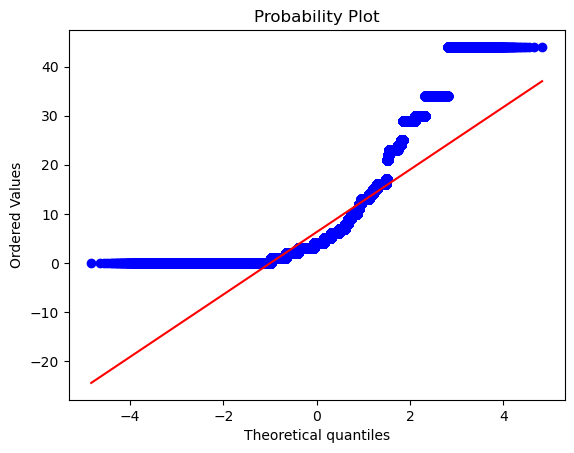

In [6]:
dfh.qqplot(model_df, "length_of_stay")

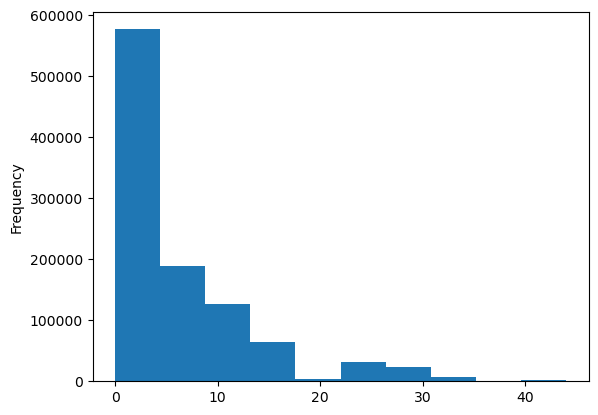

In [7]:
model_df.length_of_stay.plot(kind="hist");

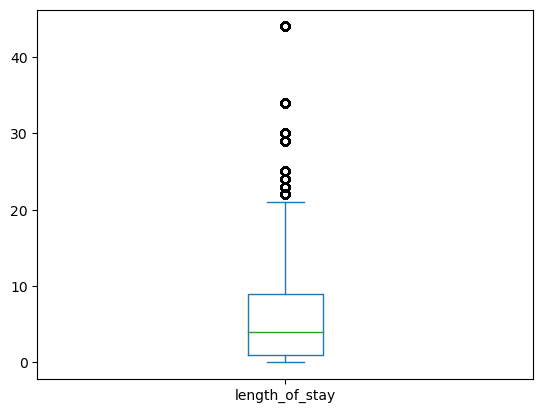

In [8]:
model_df.length_of_stay.plot(kind="box");


In [9]:
Q1 = model_df.length_of_stay.quantile(0.25)
Q3 = model_df.length_of_stay.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

model_df = model_df[(model_df.length_of_stay >= lower_bound) & (model_df.length_of_stay <= upper_bound)]
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 961449 entries, 0 to 1025832
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   drug                961449 non-null  object 
 1   age                 961449 non-null  int64  
 2   diagnosis           961449 non-null  object 
 3   gender              961449 non-null  object 
 4   admission_type      961449 non-null  object 
 5   admission_location  961449 non-null  object 
 6   insurance           961449 non-null  object 
 7   marital_status      961449 non-null  object 
 8   race                961449 non-null  object 
 9   weight              961449 non-null  float64
 10  bp_systolic         961449 non-null  float64
 11  bp_diastolic        961449 non-null  float64
 12  died                961449 non-null  bool   
 13  length_of_stay      961449 non-null  int64  
dtypes: bool(1), float64(3), int64(2), object(8)
memory usage: 103.6+ MB


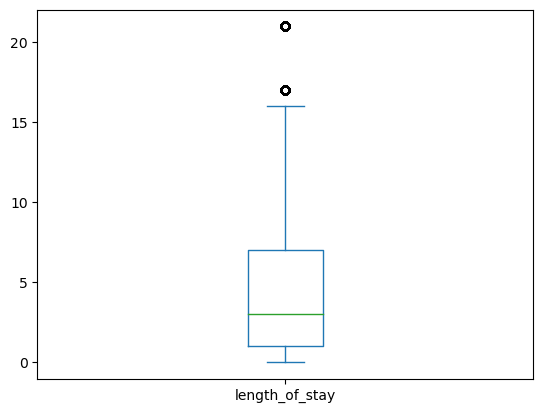

In [10]:
dfh.boxplot(model_df, "length_of_stay")

Applying a boxcox transformation so that the target variable follows a more normal distribution

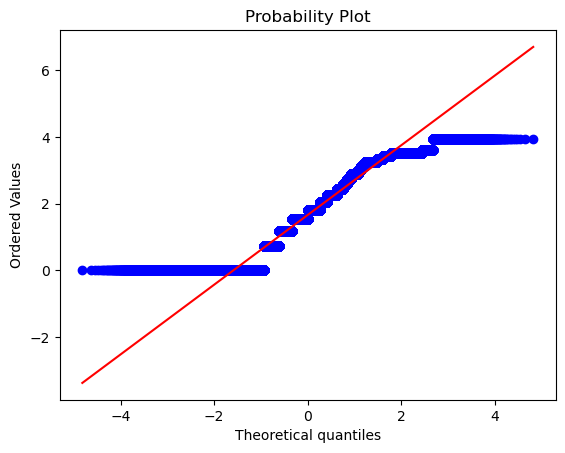

In [11]:
model_df['length_of_stay_boxcox'], box_lambda = stats.boxcox(model_df['length_of_stay'] + 1)  # +1 to avoid log(0)
dfh.drop_columns(
    model_df,[
        "length_of_stay",
    ]
)
dfh.qqplot(model_df, "length_of_stay_boxcox")

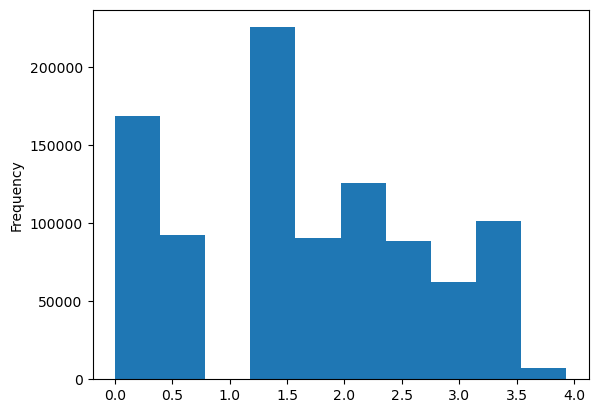

In [12]:
model_df.length_of_stay_boxcox.plot(kind="hist");

**Observations**
Although not perfect, the distribution is more normal now.

### Logistic Regression

In [13]:
los_df = model_df.copy()
dfh.drop_columns(
    los_df,[
        "died"
    ]
)
categorical = list(dfh.categorical_columns(los_df))
continuous = list(dfh.numerical_columns(los_df))
continuous.remove('length_of_stay_boxcox')

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Standardize numerical features
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  # One-hot encode categorical features
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical),
        ('num', numerical_transformer, continuous),
    ],
)
los_df.head()

,drug,age,diagnosis,gender,admission_type,admission_location,insurance,marital_status,race,weight,bp_systolic,bp_diastolic,length_of_stay_boxcox
0,Fentanyl Citrate,71,"Urinary tract infection, site not specified",F,EW EMER.,EMERGENCY ROOM,Other,SINGLE,WHITE,69.17,128.0,80.0,3.930764
1,Fentanyl Citrate,71,Acute respiratory failure,F,EW EMER.,EMERGENCY ROOM,Other,SINGLE,WHITE,69.17,128.0,80.0,3.930764
2,Fentanyl Citrate,71,"Asthma, unspecified type, unspecified",F,EW EMER.,EMERGENCY ROOM,Other,SINGLE,WHITE,69.17,128.0,80.0,3.930764
3,Fentanyl Citrate,71,Other,F,EW EMER.,EMERGENCY ROOM,Other,SINGLE,WHITE,69.17,128.0,80.0,3.930764
4,Fentanyl Citrate,71,Other,F,EW EMER.,EMERGENCY ROOM,Other,SINGLE,WHITE,69.17,128.0,80.0,3.930764


In [14]:
los_xtrain, los_xtest, los_ytrain, los_ytest = dfh.xy_split(los_df, "length_of_stay_boxcox")
los_xtrain_transformed = preprocessor.fit_transform(los_xtrain)
los_xtest_transformed = preprocessor.transform(los_xtest)
los_xtest_transformed

array([[ 0.        ,  0.        ,  0.        , ...,  0.42857811,
        -1.67857719, -1.27107304],
       [ 0.        ,  0.        ,  0.        , ..., -1.39892046,
         0.818689  , -1.27107304],
       [ 0.        ,  0.        ,  1.        , ..., -1.30004131,
        -0.94408713,  0.24967259],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.17017173,
         1.07576052, -0.15052363],
       [ 0.        ,  0.        ,  0.        , ...,  1.17017173,
         1.07576052, -0.15052363],
       [ 0.        ,  0.        ,  0.        , ..., -0.45868569,
        -1.12770964,  0.00955486]])

In [15]:
import pickle

#with open('data/los_xtrain_transformed.pkl', 'wb') as f:
#    pickle.dump(los_xtrain_transformed, f)
#with open('data/los_xtest_transformed.pkl', 'wb') as f:
#    pickle.dump(los_xtest_transformed, f)
#with open('data/los_ytrain.pkl', 'wb') as f:
#    pickle.dump(los_ytrain, f)
#with open('data/los_ytest.pkl', 'wb') as f:
#    pickle.dump(los_ytest, f)
#with open('data/preprocessor.pkl', 'wb') as f:
#    pickle.dump(preprocessor, f)
#with open('data/los_df.pkl', 'wb') as f:
#    pickle.dump(los_df, f)
#los_df.to_csv("data/los_df.csv", index=False)

In [16]:
lr = LinearRegression()
lr.fit(los_xtrain_transformed, los_ytrain)

# Predict on test set
y_pred = lr.predict(los_xtest_transformed)
dfh.evaluate_model(y_pred, los_ytest)

Mean Absolute Error (MAE): 0.52
Mean Squared Error (MSE): 0.44
Root Mean Squared Error (RMSE): 0.67
R-squared (R²): 0.38
Median Absolute Error: 0.43
Explained Variance Score: 0.38


**Observations**
As we can see, the linear regression model only explains 38% of the variance in length of stay.

### Random Forest Regression
A helper function that converts the predictions back to the original scale

In [17]:
def convert_back_to_original_scale(series, box_lambda):
    predictions_original = None
    if box_lambda != 0:
        predictions_original = (series * box_lambda + 1) ** (1 / box_lambda)
    else:
        predictions_original = np.exp(series)

    predictions_original -= 1
    return np.round(predictions_original)

In [18]:
#implementing decision tree regression
dtr = RandomForestRegressor(n_estimators=5, random_state=42)
dtr.fit(los_xtrain_transformed, los_ytrain)
# Predict on test set
y_pred_dt = dtr.predict(los_xtest_transformed)
dfh.evaluate_model(y_pred_dt, los_ytest)

Mean Absolute Error (MAE): 0.25
Mean Squared Error (MSE): 0.23
Root Mean Squared Error (RMSE): 0.48
R-squared (R²): 0.77
Median Absolute Error: 0.00
Explained Variance Score: 0.77


**Observations:**
The random forest regression model explains ***77% of the variance*** in length of stay. A  great improvement on the linear regression model's 38%.

#### Inspecting model predictions

In [18]:
y_pred_dt_series = pd.Series(np.array(y_pred_dt), name="predictions")
los_ytest_series = pd.Series(np.array(los_ytest), name="actual")
y_pred_dt_series = convert_back_to_original_scale(y_pred_dt_series, box_lambda)
los_ytest_series = convert_back_to_original_scale(los_ytest_series, box_lambda)
comparison_df = pd.concat([y_pred_dt_series, los_ytest_series], axis=1)
comparison_df.head(20)

,predictions,actual
0,0.0,0.0
1,4.0,3.0
2,4.0,2.0
3,0.0,0.0
4,1.0,1.0
5,2.0,2.0
6,0.0,0.0
7,4.0,10.0
8,0.0,0.0
9,3.0,1.0


In [19]:
test = los_df.iloc[600].to_dict()
print(f"test los: {convert_back_to_original_scale(test['length_of_stay_boxcox'], box_lambda)} days")

test los: 15.0 days


In [20]:
test_df = pd.DataFrame([test])
tempx, tempy = test_df.drop("length_of_stay_boxcox", axis=1), test_df["length_of_stay_boxcox"]
tempx_transformed = preprocessor.transform(tempx)

print(f"predicted los: {convert_back_to_original_scale(dtr.predict(tempx_transformed), box_lambda)[0]} days")


predicted los: 15.0 days
